#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 05
**CH05A What Likelihood of Loss to Expect on a Stock Portfolio?**

using the sp500 dataset

version 1.0 2021-05-05

In [58]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
from scipy.stats import norm
import seaborn as sns
from matplotlib.ticker import PercentFormatter, ScalarFormatter
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

warnings.filterwarnings("ignore")


In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/sp500/clean/"
data_out = dirname + "da_case_studies/ch05-stock-market-loss-generalize/"
output = dirname + "da_case_studies/ch05-stock-market-loss-generalize/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


In [77]:
# Import the prewritten helper functions
from py_helper_functions import *
sns.set_theme(rc=da_theme, palette=color)

In [4]:
sp500 = pd.read_csv(data_in + "SP500_2006_16_data.csv")
# sp500 = pd.read_csv("https://osf.io/h64z2/download")


In [5]:
sp500 = sp500.replace("", np.nan).replace("#N/A", np.nan).dropna().reset_index(drop=True)

Create percent return

In [6]:
sp500["pct_return"] = sp500["VALUE"].pct_change() * 100

Create date variables (we dont use these though)

In [7]:
sp500["DATE"] = pd.to_datetime(sp500["DATE"], format="%Y-%m-%d")
sp500["year"] = sp500["DATE"].dt.year
sp500["month"] = sp500["DATE"].dt.month
sp500["yearmonth"] = sp500["year"] * 100 + sp500["month"]

### Figure 5.1 Histogram of daily returns in the entire data

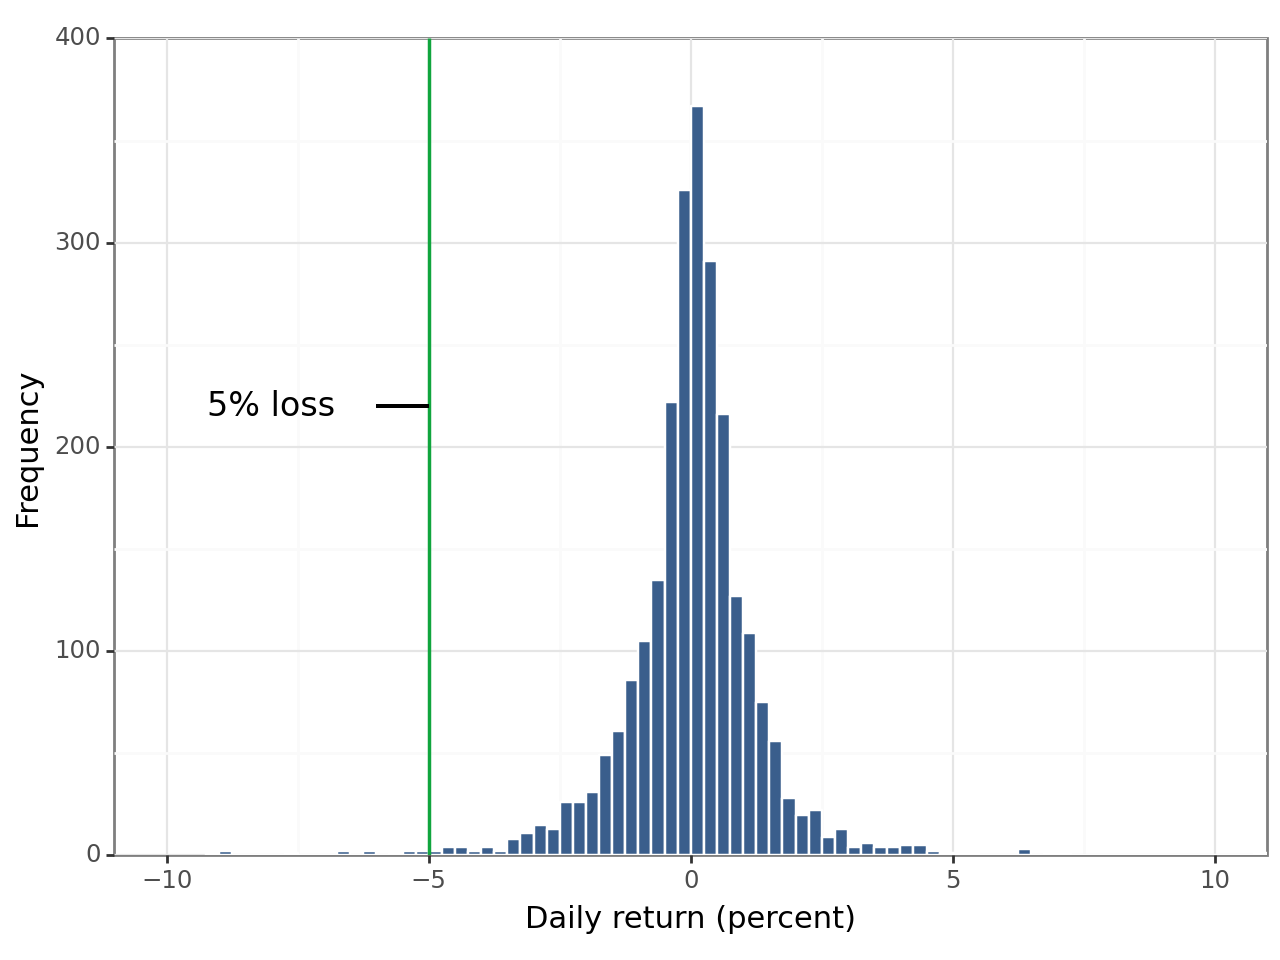

<Figure Size: (640 x 480)>

In [8]:
(
    ggplot(sp500, aes("pct_return"))
    + geom_histogram(
        binwidth=0.25, color="white", fill=color[0], boundary=0, closed="left"
    )
    + geom_vline(xintercept=-5, size=0.7, color=color[1])
    + labs(x="Daily return (percent)", y="Frequency")
    + coord_cartesian(xlim=[-10, 10], ylim=[0, 400])
    + scale_y_continuous(expand=[0, 0])
    + geom_segment(aes(x=-6, y=220, xend=-5, yend=220))
    + annotate("text", x=-8, y=220, label="5% loss", size=12)
    + theme_bw()
)


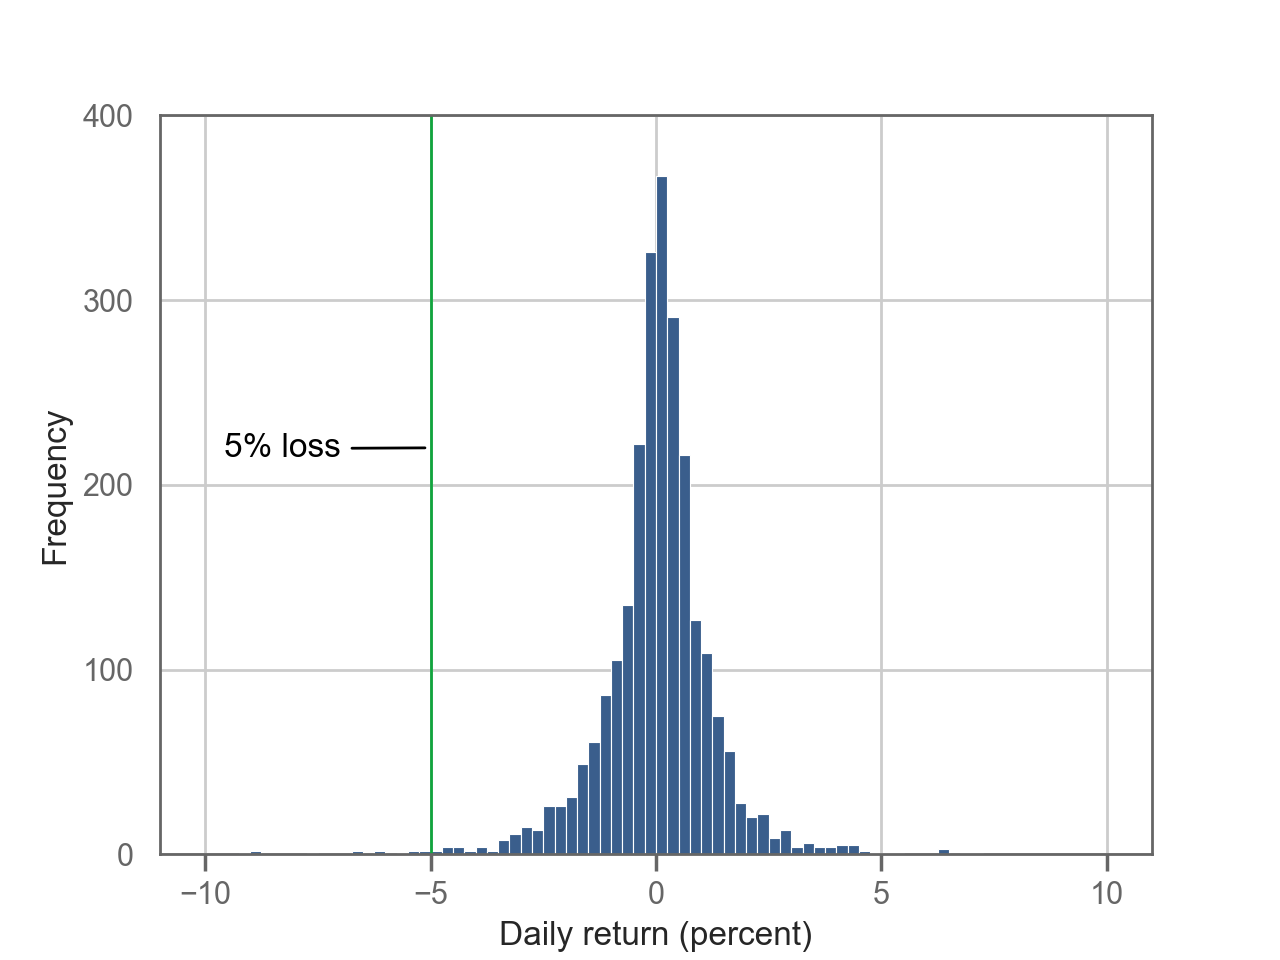

In [ ]:
sns.histplot(
    data=sp500,
    x="pct_return",
    binwidth=0.25,
    binrange=(-10,10),
    fill=True,
    color=color[0],
    alpha = 1
)


plt.axvline(x=-5, color=color[1], linewidth=1, linestyle='-')
plt.annotate(
    "5% loss",
    xy=(-5, 220), 
    xytext=(-7, 215), 
    fontsize=12,
    ha="right",
    arrowprops=dict(arrowstyle="-", color="black"),
)




plt.xlabel("Daily return (percent)")
plt.ylabel("Frequency")
plt.xlim(-11, 11)
plt.xticks(ticks=np.arange(-10, 11, 5))  
plt.ylim(0, 400)
plt.yticks(ticks=np.arange(0, 401, 100))  
plt.show()

### Figure 5.2 prep

 Create 10 000 samples, with 500 and 1000 observations in each sample, taken from sp500["pct_return"]

In every sample: for each observation, check if it is a loss of 5% or more. Then calculate the percentage of observations out of 500 or 1000 where the loss exceeds 5%. 

In [125]:
help(create_sample_frame)

Help on function create_sample_frame in module py_helper_functions:

create_sample_frame(vector: <built-in function array>, sample_size: int, n_samples=10000, with_replacement=False, seed=42) -> List[<built-in function array>]
    Function for a specified number of samples.
    Draws a specified number of observations from a vector, either with or without replacement.
    Returns the matrix of samples.

    Used in `ch05-stock-market-loss-generalize.ipynb`

       Parameters
    ----------
    vector : np.array
        Vector of observations.
    sample_size : int
        Sample size, you want to draw.
        Set it len(vector) for bootstrap sampling.
    n_samples : int, default=10000
        Number of samples.
    with_replacement : bool, default=False
        Whether to perform sampling with or without
        replacement. Set `True` for bootstrap sampling.
    seed : int,default=42
        Random seed for reproducibility.



In [36]:
nobs_1000 = np.mean(
    create_sample_frame(sp500["pct_return"], 1000, with_replacement=False) < -5,
    axis=1,
)
nobs_500 = np.mean(
    create_sample_frame(sp500["pct_return"], 500, with_replacement=False) < -5,
    axis=1,
)

In [37]:
nobs_df = pd.DataFrame({"nobs_500": nobs_500, "nobs_1000": nobs_1000}) * 100

In [38]:
error = (
    norm.ppf(0.975) * np.std(nobs_df["nobs_1000"]) / np.sqrt(len(nobs_df["nobs_1000"]))
)
left = np.mean(nobs_df["nobs_1000"]) - error
right = np.mean(nobs_df["nobs_1000"]) + error


### Figure 5.2

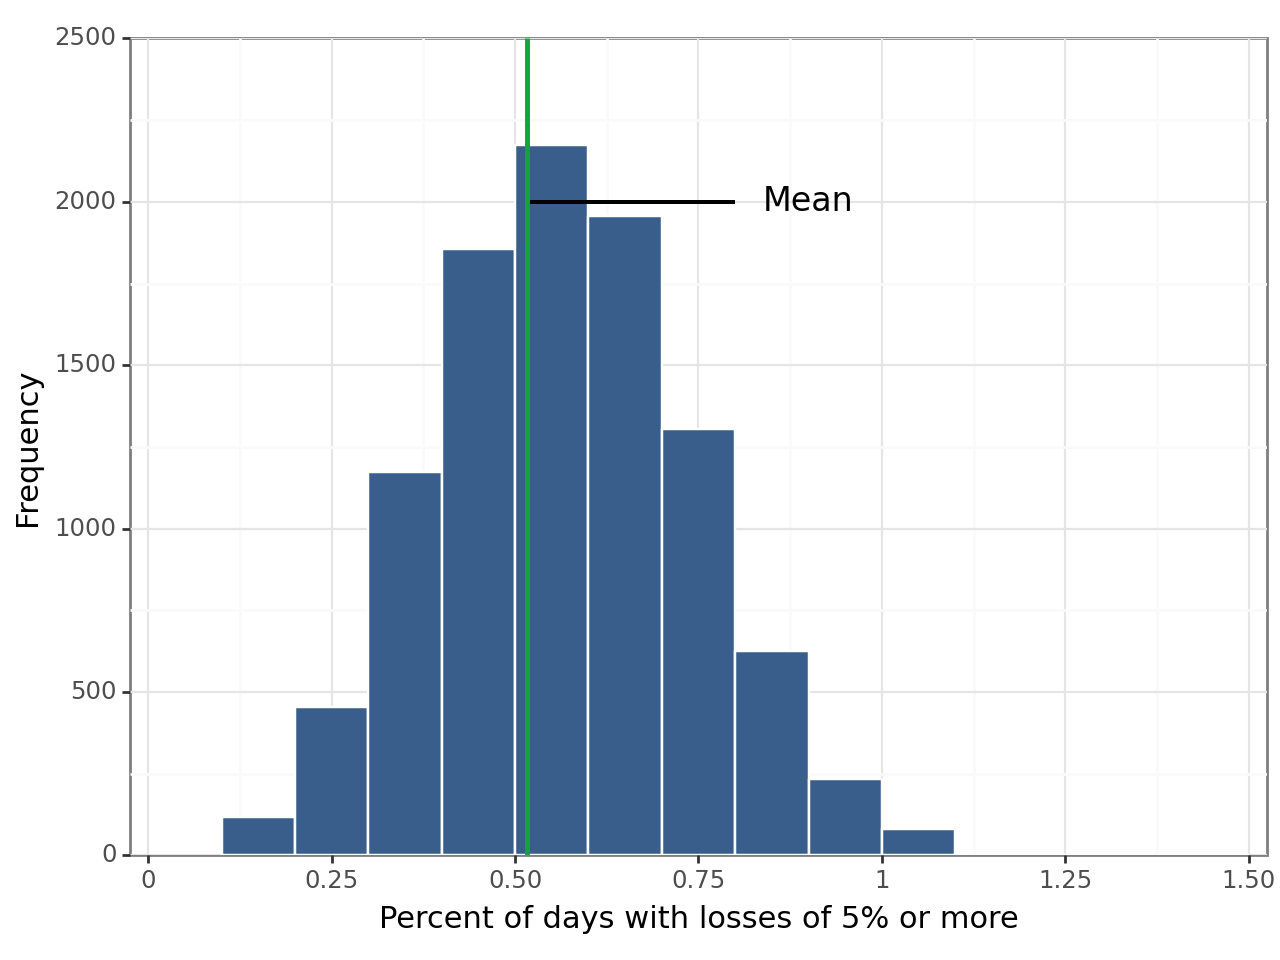

<Figure Size: (640 x 480)>

In [39]:
(
    ggplot(nobs_df, aes("nobs_1000"))
    + geom_histogram(
        binwidth=0.1,
        color="white",
        fill=color[0],
        alpha=0.8,
        center=0.75,
        closed="left",
    )
    + labs(x="Percent of days with losses of 5% or more", y="Frequency")
    + geom_vline(aes(xintercept=nobs_df["nobs_1000"].mean()), color=color[1], size=1)
    + coord_cartesian(xlim=[0, 1.5], ylim=(0, 2500))
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 1.5), breaks=seq(0, 1.5, 0.25))
    + scale_y_continuous(
        expand=(0.00, 0.00), limits=(0, 2500), breaks=seq(0, 2500, 500)
    )
    + geom_segment(aes(x=0.8, y=2000, xend=0.52, yend=2000))
    + annotate("text", x=0.9, y=2000, label="Mean", size=12)
    + theme_bw()
)

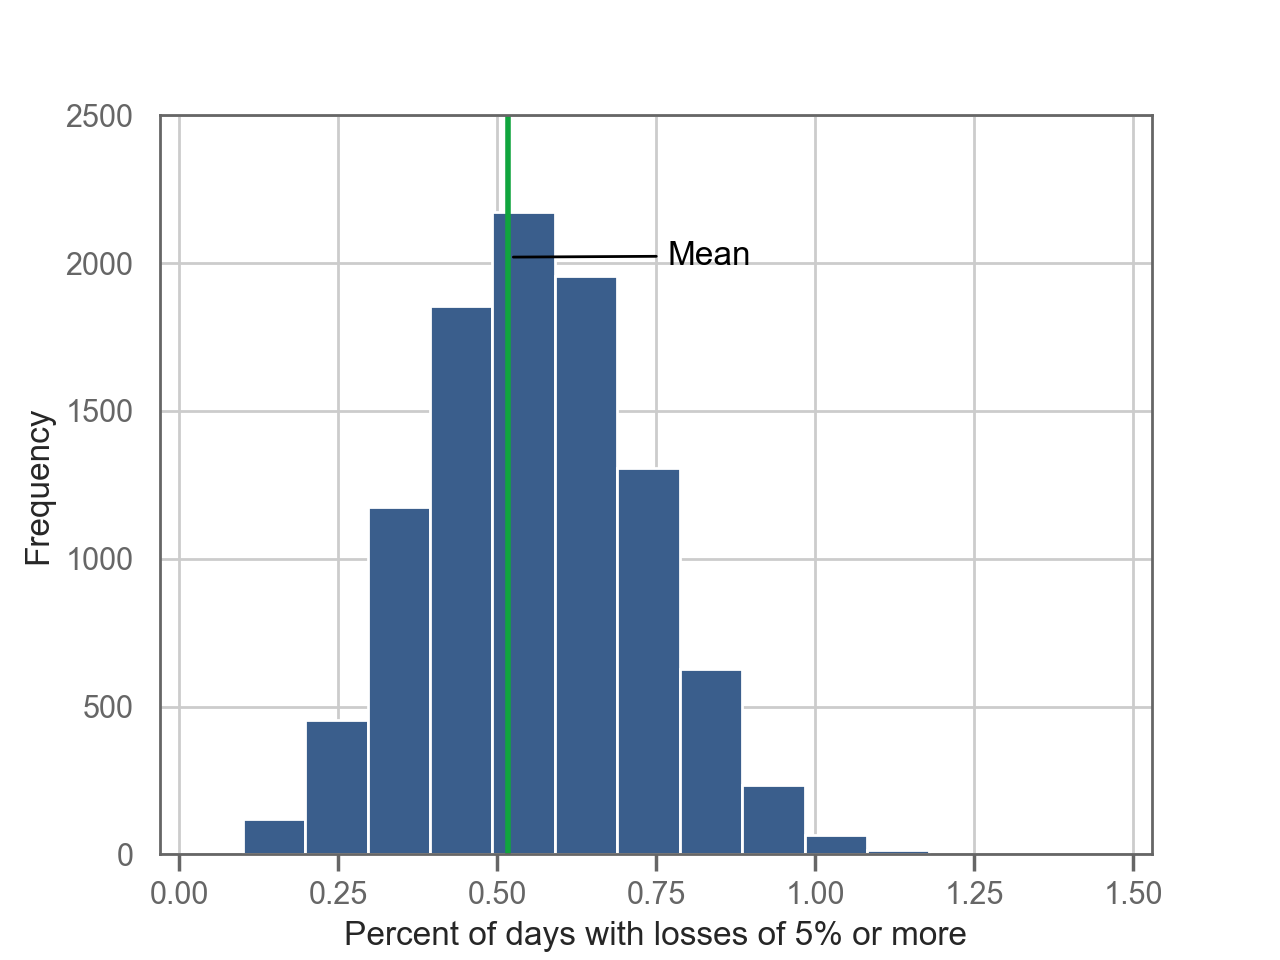

In [57]:
sns.histplot(
    data=nobs_df,
    x="nobs_1000",
    binwidth=0.1,
    binrange=(0.1,1.18),
    fill=True,
    color=color[0],
    alpha = 1
)


plt.axvline(x=nobs_df["nobs_1000"].mean(), color=color[1], linewidth=2, linestyle='-')
plt.annotate(
    "Mean",
    xy=(nobs_df["nobs_1000"].mean(), 2020), 
    xytext=(0.9, 1995), 
    fontsize=12,
    ha="right",
    arrowprops=dict(arrowstyle="-", color="black"),
)




plt.xlabel("Percent of days with losses of 5% or more")
plt.ylabel("Frequency")
plt.xlim(-0.03, 1.53)
plt.xticks(ticks=np.arange(0, 1.53, 0.25))  
plt.ylim(0, 2500)
plt.yticks(ticks=np.arange(0, 2501, 500))  
plt.show()

### Figure 5.3 

Not working with epanechnikov kernel

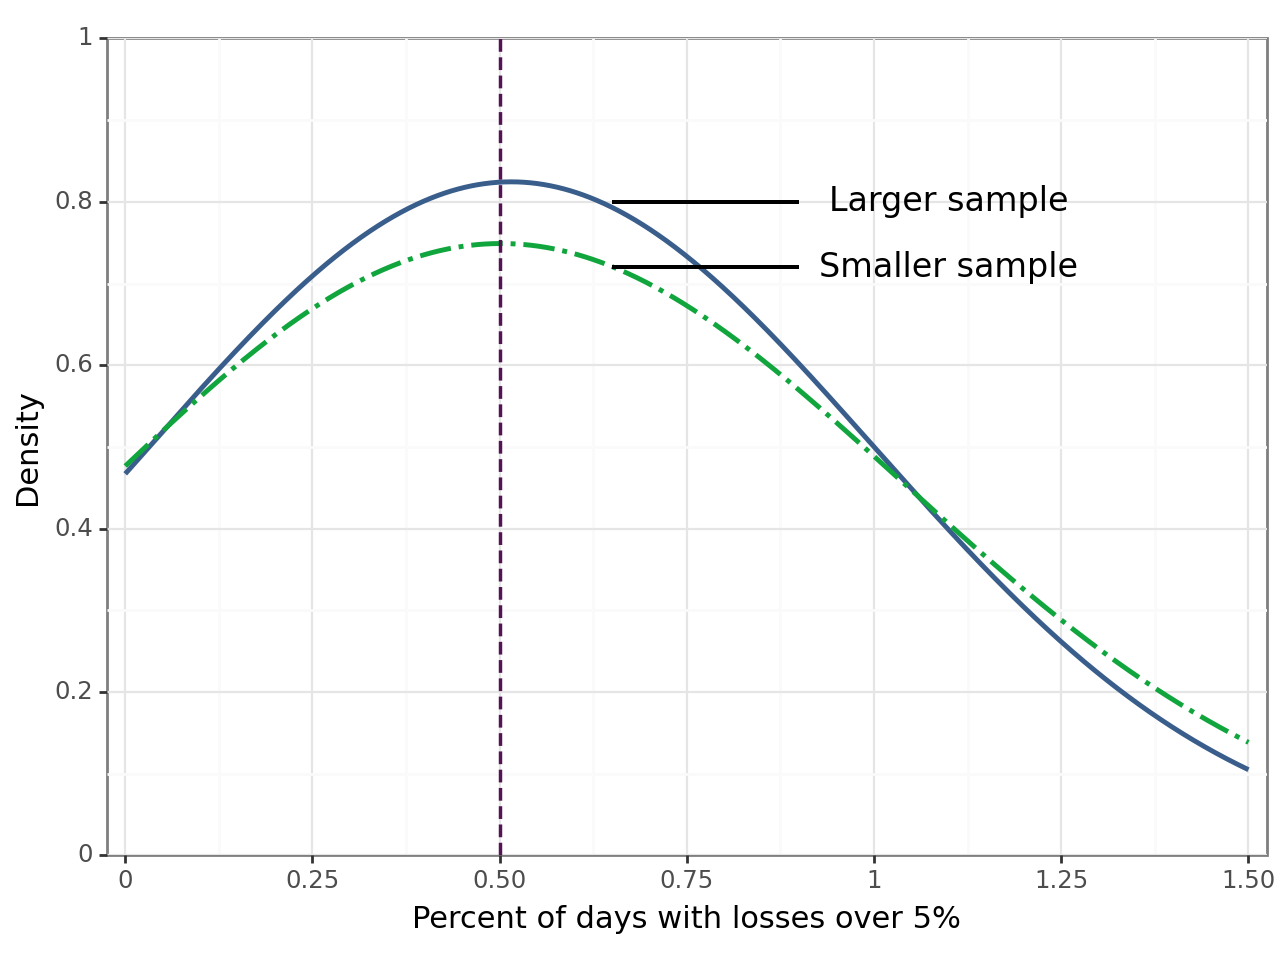

<Figure Size: (640 x 480)>

In [106]:
(
    ggplot(nobs_df)
    + stat_density(aes(x="nobs_1000"), color=color[0], geom="line", bw=0.45, size=1)
    + stat_density(
        aes("nobs_500"),
        color=color[1],
        geom="line",
        bw=0.45,
        linetype="dashdot",
        size=1,
    )
    + labs(x="Percent of days with losses over 5%", y="Density")
    + geom_vline(xintercept=0.5, color=color[2], size=0.7, linetype="dashed")
    + geom_segment(aes(x=0.9, y=0.8, xend=0.65, yend=0.8), size=0.5)
    + annotate("text", x=1.1, y=0.8, label="Larger sample", size=12)
    + geom_segment(aes(x=0.9, y=0.72, xend=0.65, yend=0.72), size=0.5)
    + annotate("text", x=1.1, y=0.72, label="Smaller sample", size=12)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 1.5), breaks=seq(0, 1.5, 0.25))
    + scale_y_continuous(expand=(0.00, 0.00), limits=(0, 1), breaks=seq(0, 1, 0.2))
    + theme_bw()
    + theme(
        legend_position="none",
    )
)

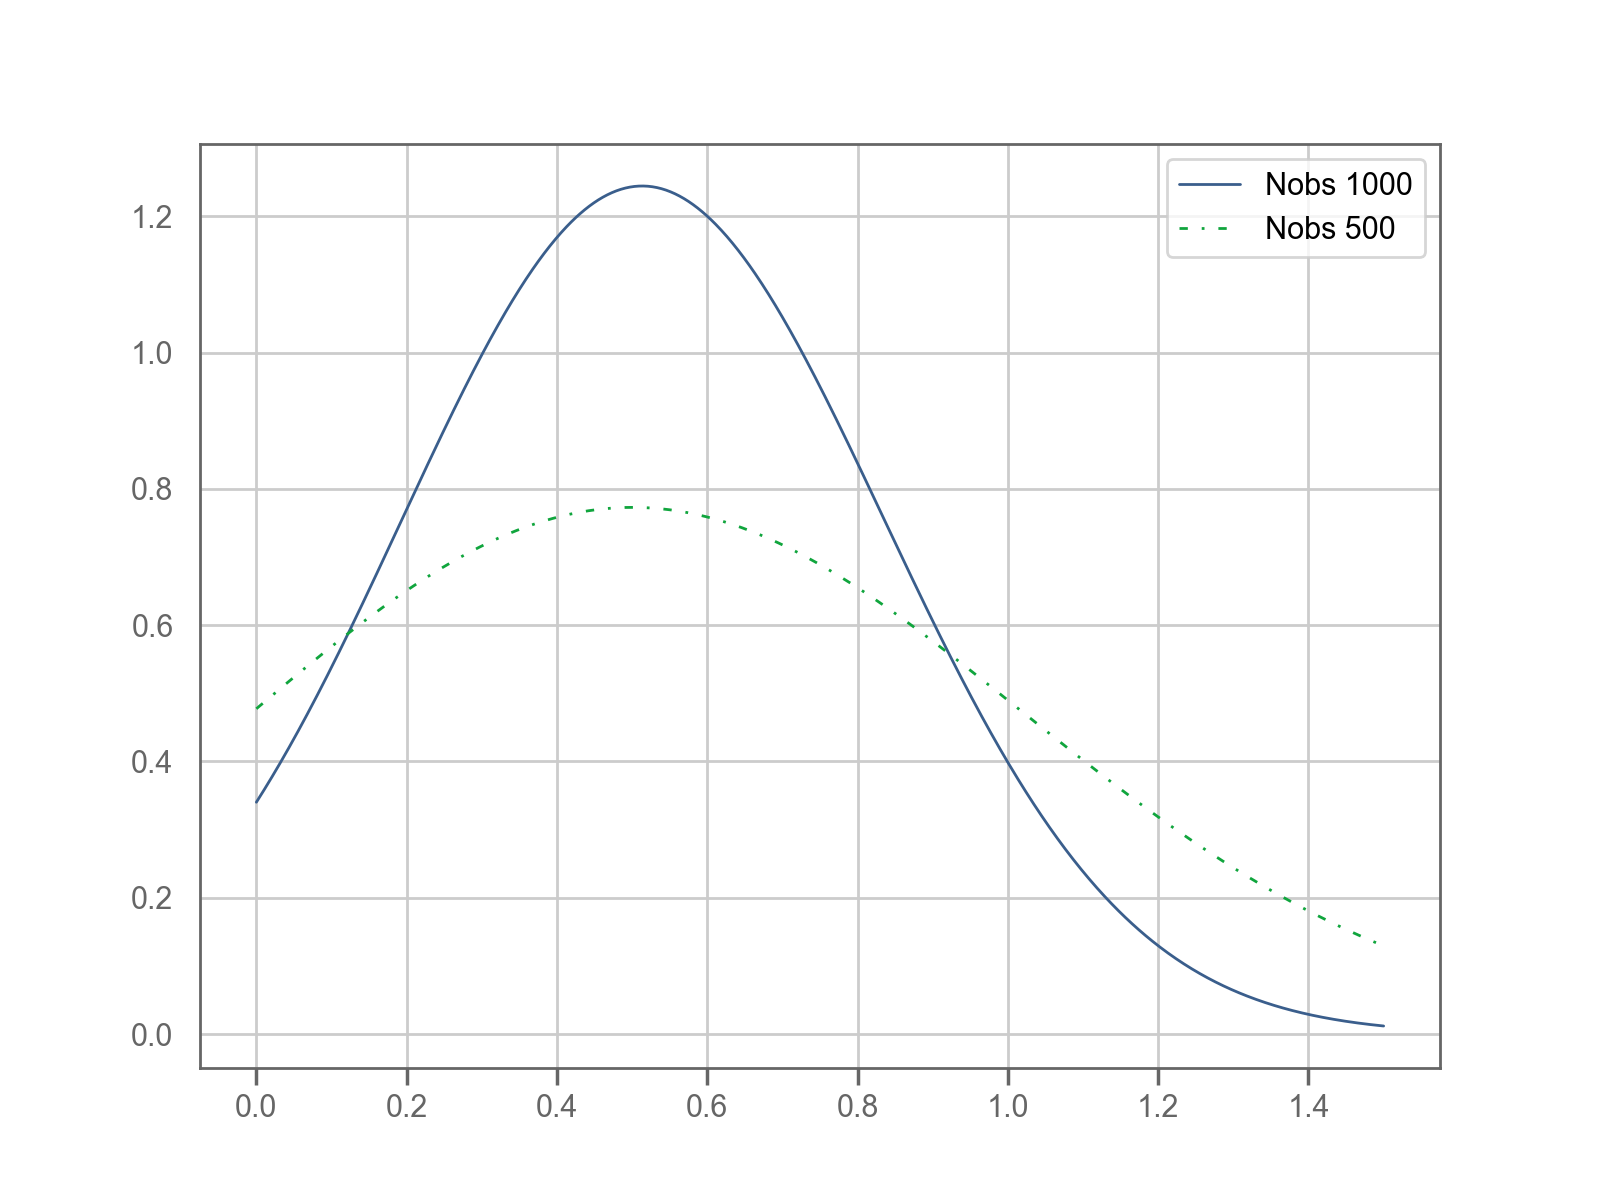

In [118]:

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Calculate density for nobs_1000 and plot
kde_1000 = gaussian_kde(nobs_df["nobs_1000"]
                        , bw_method=1.5
                        )
x_vals = np.linspace(0, 1.5, 1000)
sns.lineplot(
    x=x_vals,
    y=kde_1000(x_vals),
    color=color[0],
    linewidth=1,
    ax=ax,
    label="Nobs 1000",
)
x_vals = np.linspace(0, 1.5, 500)
# Calculate density for nobs_500 and plot
kde_500 = gaussian_kde(nobs_df["nobs_500"]
                       , bw_method=1.5
                       )
sns.lineplot(
    x=x_vals,
    y=kde_500(x_vals),
    color=color[1],
    linestyle=(0, (3, 5, 1, 5)),  # Dashdot pattern
    linewidth=1,
    ax=ax,
    label="Nobs 500",
)


plt.show()

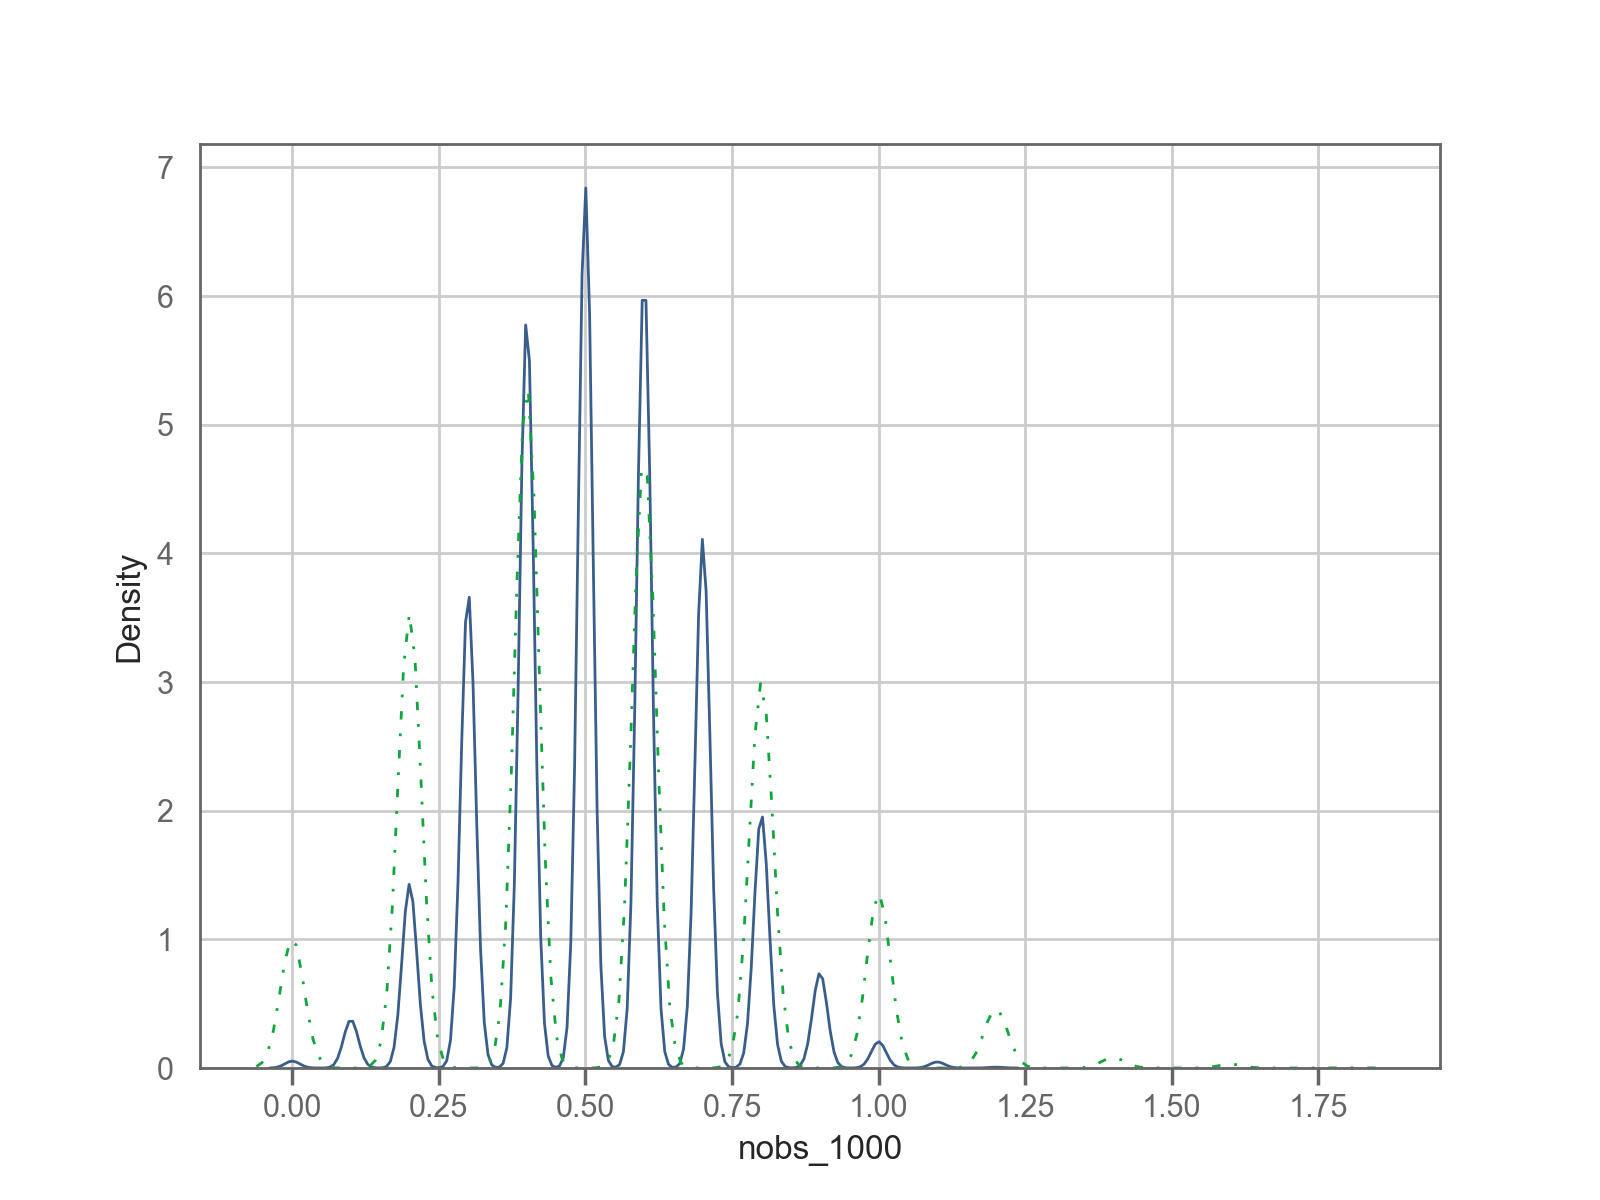

In [135]:
fig, ax = plt.subplots(figsize=(8, 6))

# Density plot for nobs_1000
sns.kdeplot(
    x=nobs_df["nobs_1000"],
    bw_adjust=0.45,
    color=color[0],
    linewidth=1,
    ax=ax,
    label="Nobs 1000",
)

# Density plot for nobs_500
sns.kdeplot(
    x=nobs_df["nobs_500"],
    bw_adjust=0.45,
    color=color[1],
    linestyle=(0, (3, 5, 1, 5)),  # Dashdot pattern
    linewidth=1,
    ax=ax,
    label="Nobs 500",
)
plt.show()

In [132]:
nobs_df['nobs_500'].min()

0.0

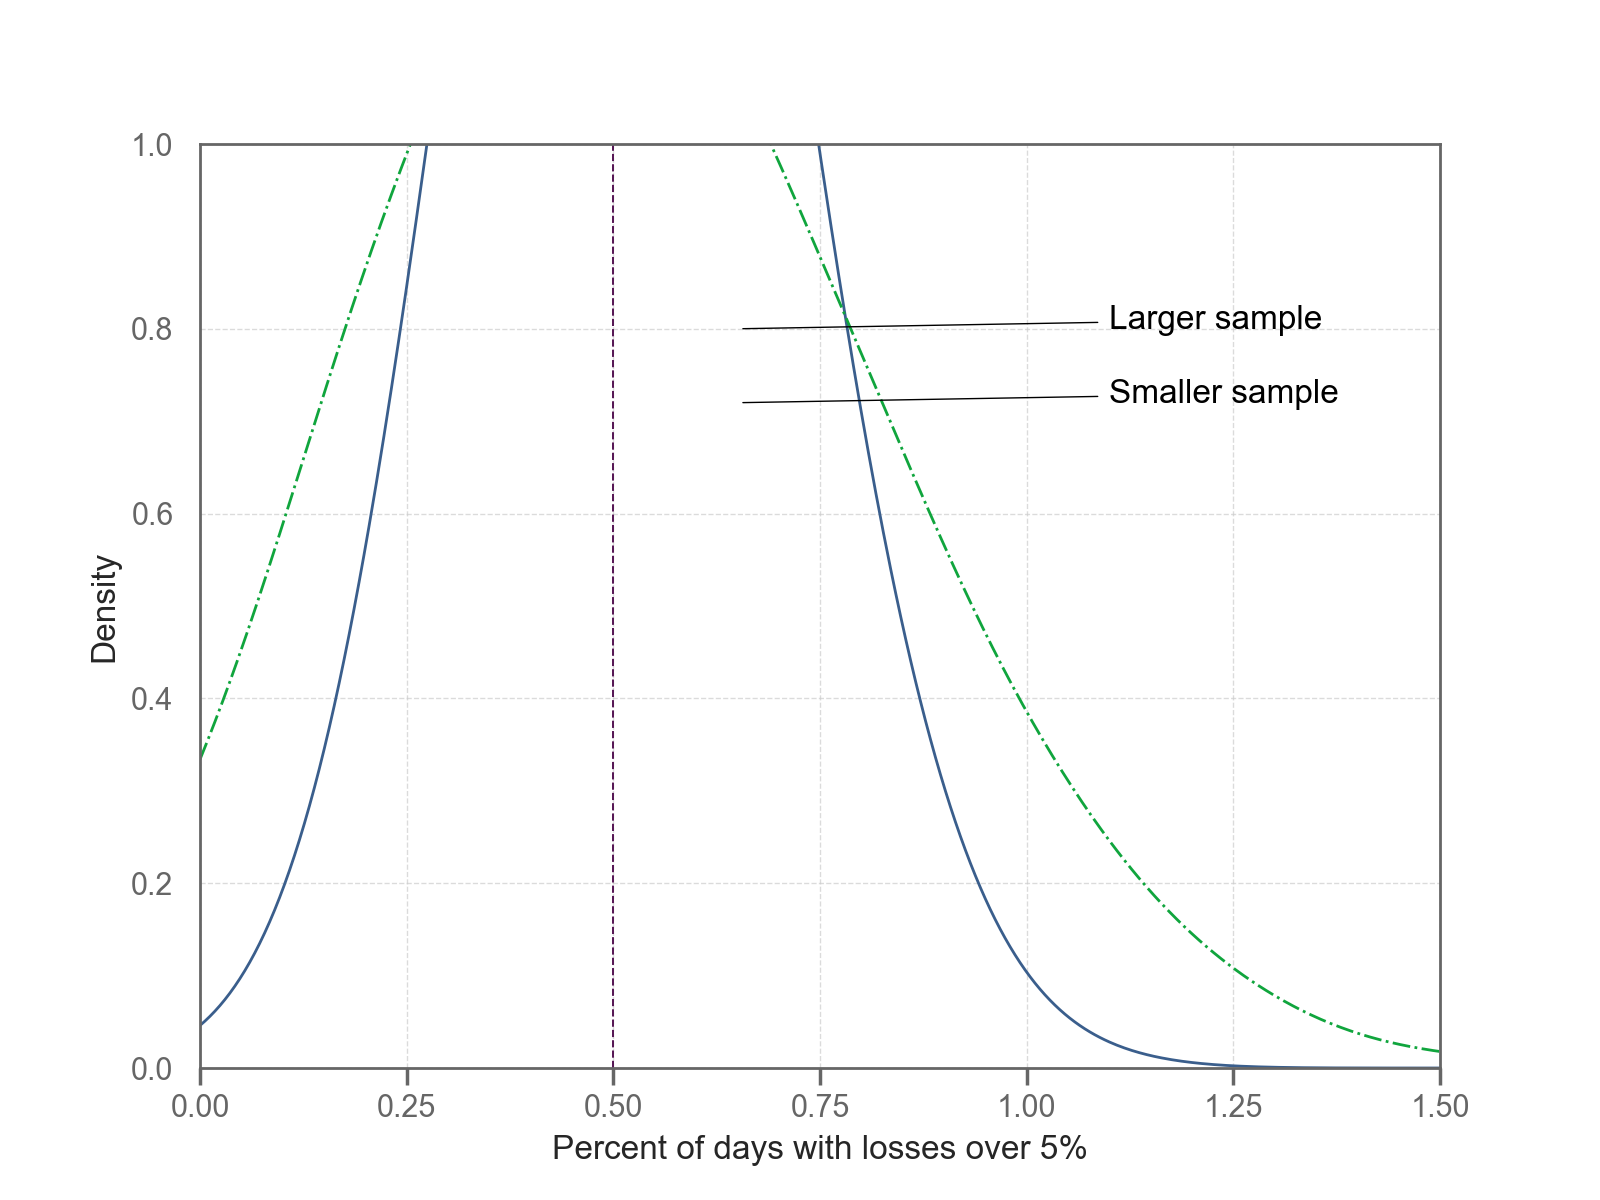

In [59]:
# Define data columns (ensure nobs_df["nobs_1000"] and nobs_df["nobs_500"] exist)
x_1000 = nobs_df["nobs_1000"]
x_500 = nobs_df["nobs_500"]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Calculate density for nobs_1000
kde_1000 = gaussian_kde(x_1000, bw_method=0.45)
x_vals_1000 = np.linspace(0, 1.5, 500)  # Generate x-values for density curve
y_vals_1000 = kde_1000(x_vals_1000)
ax.plot(x_vals_1000, y_vals_1000, color=color[0], linewidth=1, label="nobs_1000")

# Calculate density for nobs_500
kde_500 = gaussian_kde(x_500, bw_method=0.45)
x_vals_500 = np.linspace(0, 1.5, 500)
y_vals_500 = kde_500(x_vals_500)
ax.plot(x_vals_500, y_vals_500, color=color[1], linewidth=1, linestyle="dashdot", label="nobs_500")

# Add vertical line
ax.axvline(x=0.5, color=color[2], linewidth=0.7, linestyle="dashed")

# Add annotation lines and text
ax.annotate("Larger sample", xy=(0.65, 0.8), xytext=(1.1, 0.8),
            ha="left", fontsize=12,
            arrowprops=dict(arrowstyle="-", color="black", linewidth=0.5))
ax.annotate("Smaller sample", xy=(0.65, 0.72), xytext=(1.1, 0.72),
            ha="left", fontsize=12,
            arrowprops=dict(arrowstyle="-", color="black", linewidth=0.5))

# Set axis labels
ax.set_xlabel("Percent of days with losses over 5%", fontsize=12)
ax.set_ylabel("Density", fontsize=12)

# Set x and y axis limits and ticks
ax.set_xlim(0, 1.5)
ax.set_ylim(0, 1)
ax.set_xticks(np.arange(0, 1.51, 0.25))
ax.set_yticks(np.arange(0, 1.1, 0.2))

# Apply grid and style
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
ax.set_axisbelow(True)

# Remove legend if not needed
ax.legend().set_visible(False)
plt.show()

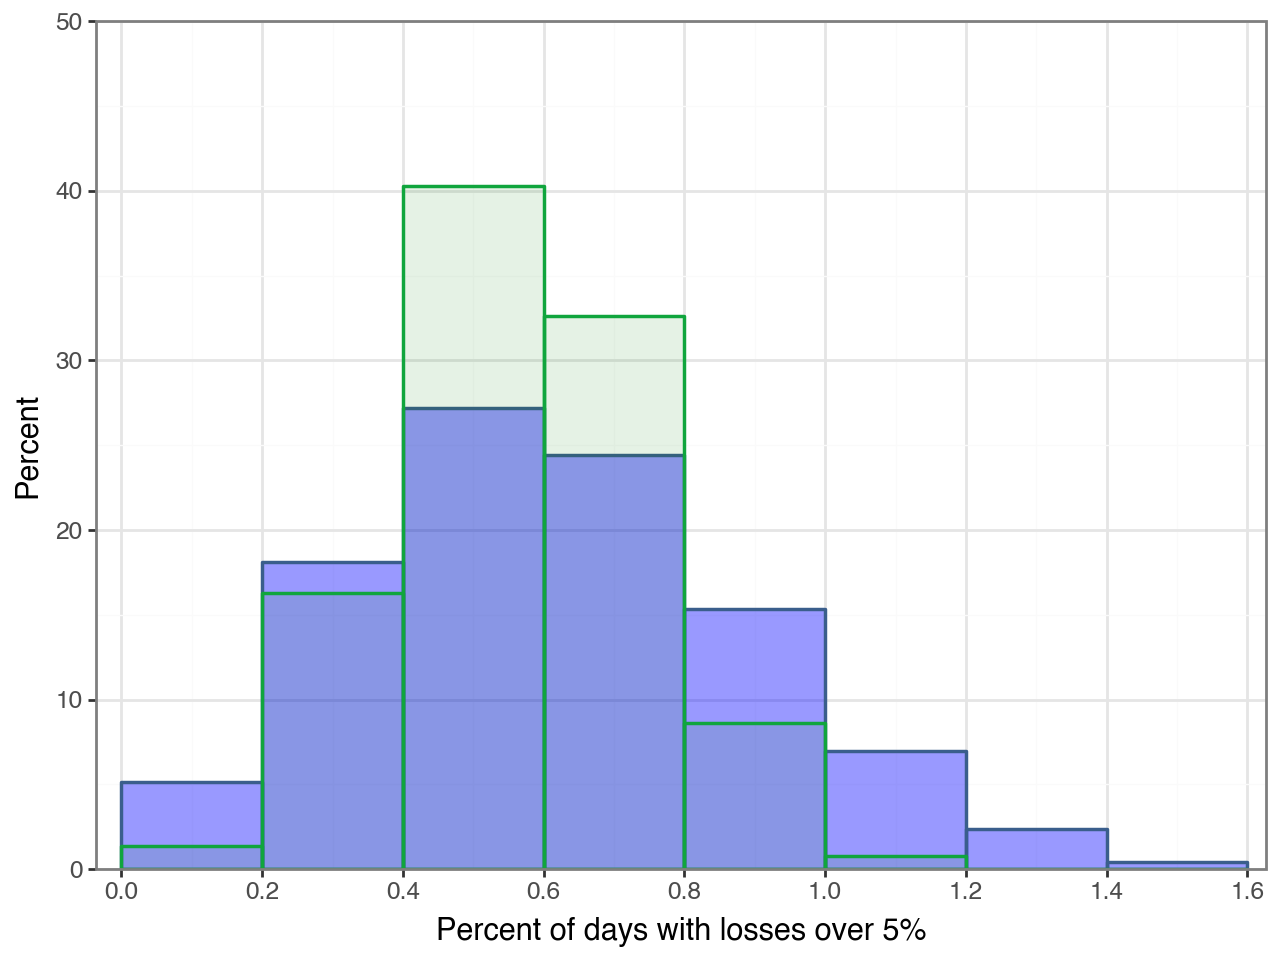

In [21]:
(
    ggplot(nobs_df)
    + geom_histogram(
        aes(x="nobs_500", y="stat(count)/sum(stat(count))*100"),
        color=color[0],
        fill="blue",
        binwidth=0.2,
        center=0.5,
        size=0.7,
        alpha=0.4,
        closed="left",
    )
    + geom_histogram(
        aes(x="nobs_1000", y="stat(count)/sum(stat(count))*100"),
        color=color[1],
        fill="green",
        binwidth=0.2,
        center=0.5,
        alpha=0.1,
        size=0.7,
        closed="left",
    )
    + ylab("Percent")
    + xlab("Percent of days with losses over 5%")
    + scale_x_continuous(
        expand=(0.01, 0.01), limits=(-0.01, 1.6), breaks=seq(0, 1.6, 0.2)
    )
    + scale_y_continuous(expand=(0.00, 0.00), limits=(0, 50))
    + scale_color_manual(
        labels=("N = 1000", "N = 500"), name="", values=(color[1], color[0])
    )
    + scale_alpha_identity()
    + scale_fill_identity()
    + theme_bw()
    + theme(
        legend_direction="horizontal",
    )
)


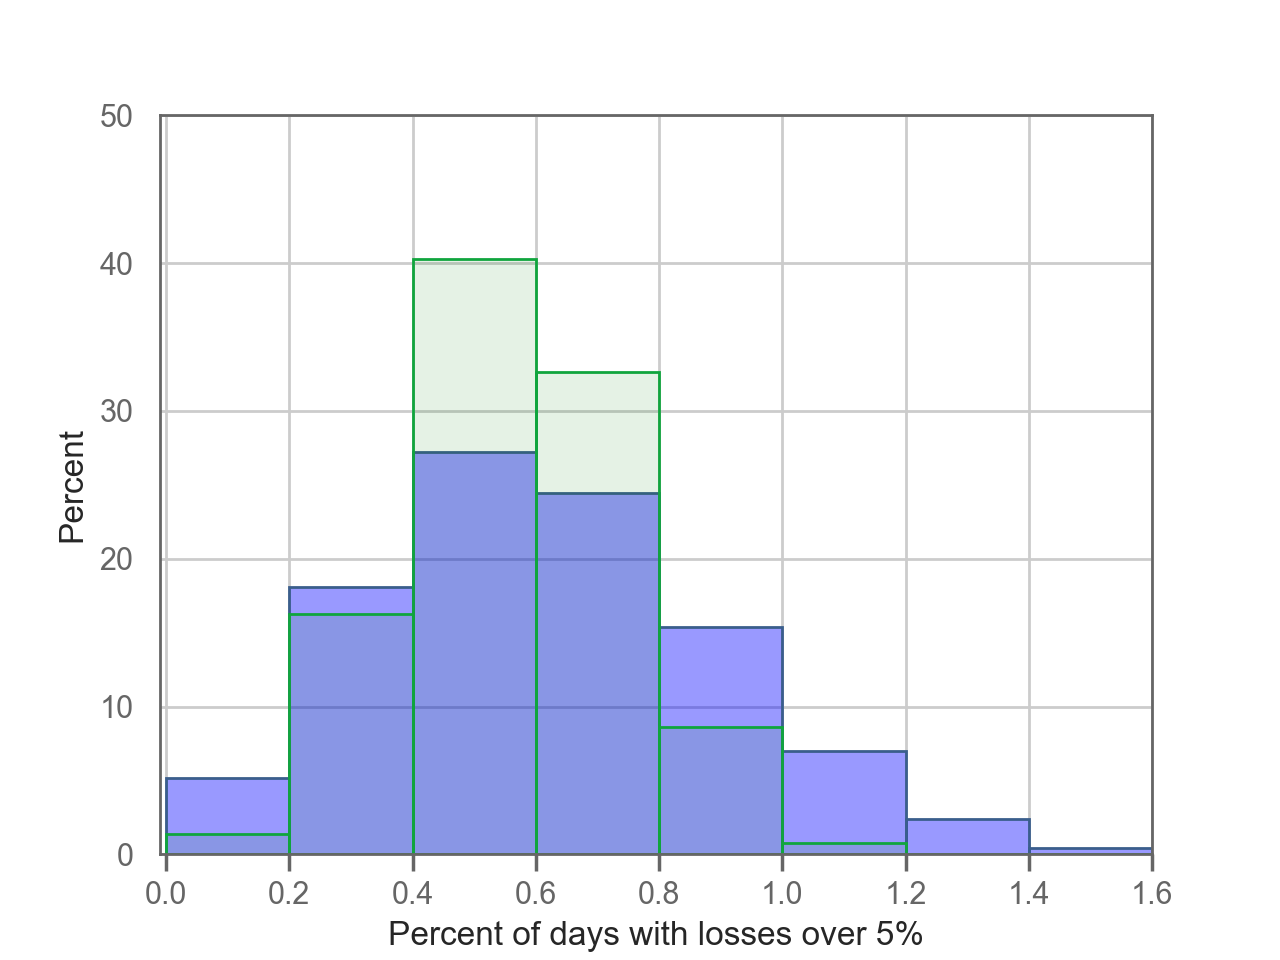

In [91]:
fig, ax = plt.subplots()
sns.histplot(
    nobs_df["nobs_500"],
    binwidth=0.2,
    binrange=(0,1.59999),  
    stat="percent",  
    color="blue",
    edgecolor=color[0],
    alpha=0.4,
    linewidth=1,
    ax=ax,
    label="N = 500",
)

sns.histplot(
    nobs_df["nobs_1000"],
    binwidth=0.2,
    binrange=(0,1.59999), 
    stat="percent",
    color="green",
    edgecolor=color[1],
    alpha=0.1,
    linewidth=1,
    ax=ax,
    label="N = 1000",
)

ax.set_xlabel("Percent of days with losses over 5%", fontsize=12)
ax.set_ylabel("Percent", fontsize=12)
ax.set_xlim(-0.01, 1.6)
ax.set_ylim(0, 50) 
ax.set_xticks(np.arange(0, 1.61, 0.2))
plt.show()

Create bootstrap samples

In [60]:
bootstrap_samples = create_sample_frame(
    sp500["pct_return"], len(sp500["pct_return"]), with_replacement=True
)

Calculate percent of days wit losses over  thresholds from -1 to 10

In [61]:
bootstrap_loss_results = pd.DataFrame(
    [
        np.mean(bootstrap_samples < -1 * pct_loss, axis=1) * 100
        for pct_loss in range(1, 11)
    ],
    index=[f"loss{i}" for i in range(1, 11)],
).T

Plot percent of days with losses over -5%

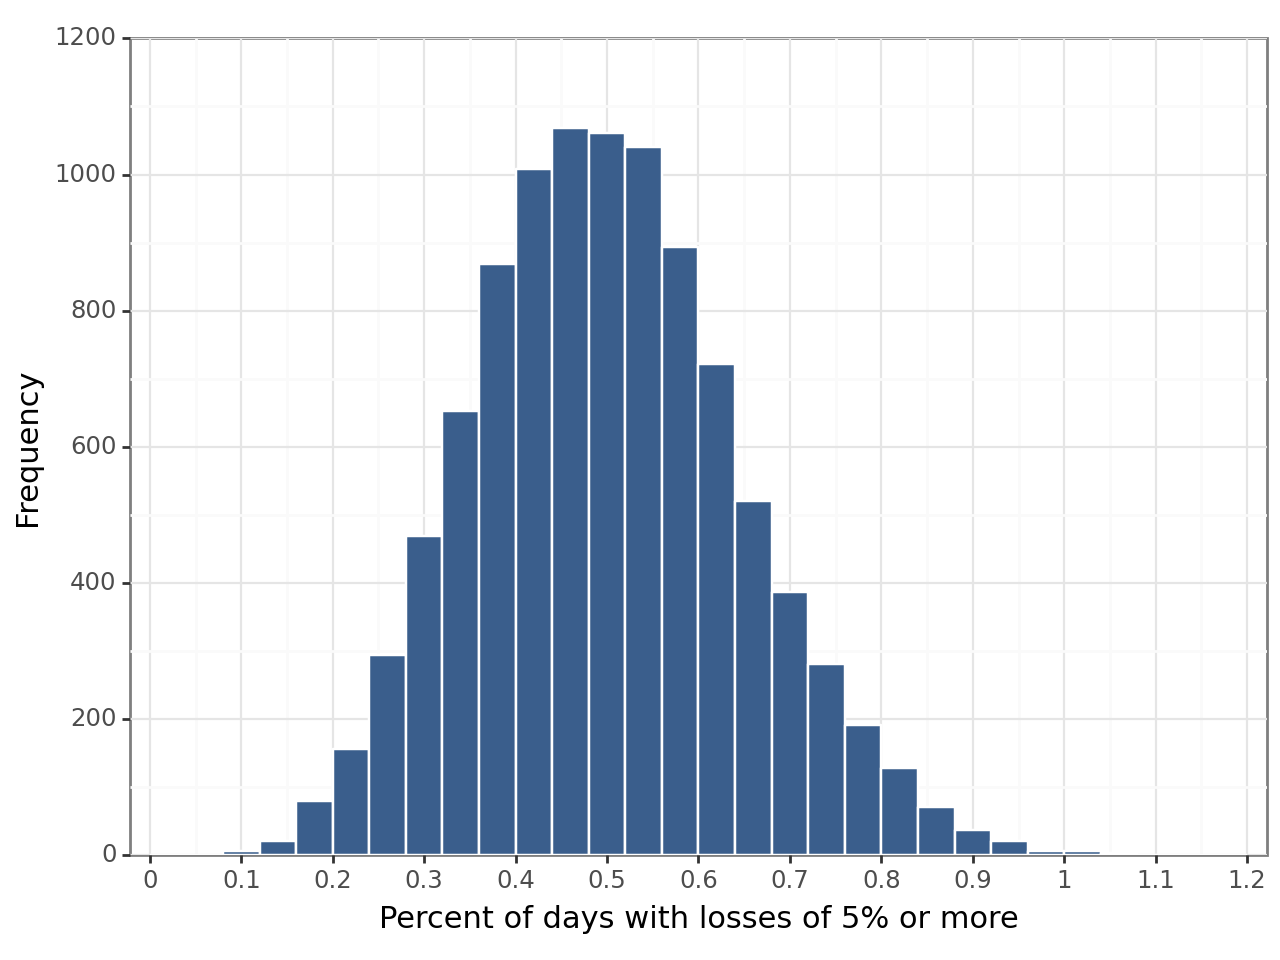

<Figure Size: (640 x 480)>

In [62]:
(
    ggplot(bootstrap_loss_results, aes("loss5"))
    + geom_histogram(
        fill=color[0], color="white", binwidth=0.04, boundary=0, closed="left"
    )
    + scale_y_continuous(expand=(0, 0), limits=(0, 1200), breaks=seq(0, 1200, 200))
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 1.2), breaks=seq(0, 1.2, 0.1))
    + labs(x="Percent of days with losses of 5% or more", y="Frequency")
    + theme_bw()
)


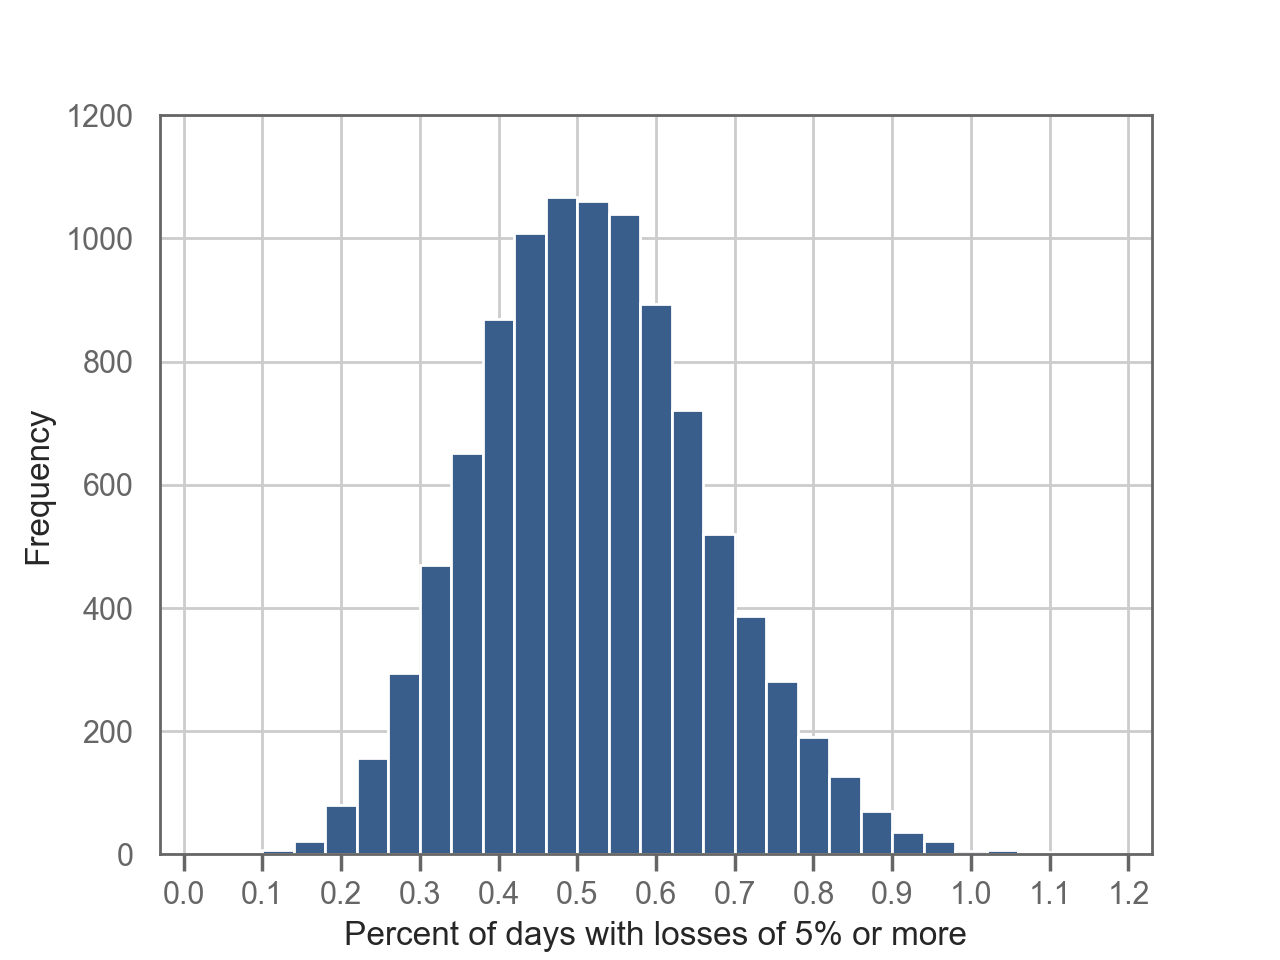

<Figure size 1000x600 with 0 Axes>

In [64]:
sns.histplot(
    data=bootstrap_loss_results,
    x="loss5",
    binwidth=0.04,
    binrange=(0.1,1.18),
    fill=True,
    color=color[0],
    alpha = 1
)





plt.xlabel("Percent of days with losses of 5% or more")
plt.ylabel("Frequency")
plt.xlim(-0.03, 1.23)
plt.xticks(ticks=np.arange(0, 1.23, 0.1))  
plt.ylim(0, 1200)
plt.yticks(ticks=np.arange(0, 1201, 200))  
plt.figure(figsize=(10,6))
plt.show()